# Data Wrangling. Analizando mi filmoteca.

En este notebook vamos a analizar una base de datos de una filmoteca. Esta base de datos está en el archivo _movies.dat_. 
El objetivo en esta ocasión será conocer los géneros más populares de la filmoteca, cuando fueron grabadas sus peliculas y analizar las relaciones entre géneros.

## 1. Ingesta de datos y preprocesado.

**Librerías**

In [1]:
# Carga de librerías

# Data wrangling
import numpy as np
import pandas as pd

# Graficos
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline 
import seaborn as sns

sns.set_theme()

### 1.1. Carga del archivo.

Podemos leer el archivo _movies.dat_ con la función pd.read_table de pandas. Para ello hay que tener en cuenta que los datos están separados por el caracter :: y que la tabla no tiene cabecera. 

In [2]:
# Cargo el archivo con la funcion read_table
movies=pd.read_table('movies.dat',sep='::', header=None , engine='python')

In [3]:
#Renombro las columnas
movies.columns=['Id','Name', 'Category']
movies.head(3)

,Id,Name,Category
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        3883 non-null   int64 
 1   Name      3883 non-null   object
 2   Category  3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


**Buscando missing values y registros duplicados.**

In [5]:
movies[movies.isna()].sum()

Id          0.0
Name        0.0
Category    0.0
dtype: float64

In [6]:
movies[movies.duplicated()]

,Id,Name,Category


La tabla tiene tres variables (Id, Name y Category) y 3883 observaciones.
   - **Id** es un código de identificación de la película dentro de nuestra base de datos.
   - **Name** es una variable que contiene el nombre y la fecha de grabación.
   - **Category** informa sobre los géneros que están etiquetados en esa pelíca. Cada título puede estar catalogado en más de una categoría y estas categorías están separadas por el carácter "_|_".

Nuestra tabla no tiene valores nulos ni duplicados.



### 1.2. Prepocesado.

Está claro que dentro de estas tres variables se puede extraer algo más de información; en este apartado vamos a preparar el dataset para facilitar su análisis. 

Por un lado puedo extraer fácilmente la fecha de la variable _Name_. Además a partir de la fecha puedo inferir la década.

Si queremos conocer como han evolucionado los géneros favoritos a lo largo del tiempo la década será util en nuestro storytelling para facilitar el análisis puesto que agregaremos los datos en menos grupos. 

#### 1.2.1. Nuevas variables: año y década.

In [7]:
# Extraigo la fecha
movies['Year']=movies.Name.str.slice(-5,-1).astype('int')
movies['Year'].unique()

array([1995, 1994, 1996, 1976, 1993, 1992, 1988, 1967, 1964, 1977, 1965,
       1982, 1962, 1990, 1991, 1989, 1937, 1940, 1969, 1981, 1973, 1970,
       1960, 1955, 1956, 1959, 1968, 1980, 1975, 1986, 1948, 1943, 1963,
       1950, 1946, 1987, 1997, 1974, 1958, 1949, 1972, 1998, 1933, 1952,
       1951, 1957, 1961, 1954, 1934, 1944, 1942, 1941, 1953, 1939, 1947,
       1945, 1938, 1935, 1936, 1926, 1932, 1930, 1971, 1979, 1966, 1978,
       1985, 1983, 1984, 1931, 1922, 1927, 1929, 1928, 1925, 1923, 1999,
       1919, 2000, 1920, 1921])

In [8]:
# Extraigo la decada
movies['Decade']=(((movies.Year-1900)/10).astype('int')*10).astype('str')+'s'
movies['Decade'].unique()

array(['90s', '70s', '80s', '60s', '30s', '40s', '50s', '20s', '10s',
       '100s'], dtype=object)

La década de los 10s solo tiene registros del año 1919 y las películas de la década de los 100s se corresponde con el año 2000. Para facilitar el análisis asumiré que el año 1919 pertenece a la década de los años 20 y el año 2000 está dentro de los 90.

In [9]:
# Asimilo 1919 a la decada de los 20s y 2000 a los 90s.
movies.loc[movies['Decade']=='100s','Decade']='90s'
movies.loc[movies['Decade']=='10s','Decade']='20s'
movies['Decade'].unique()

array(['90s', '70s', '80s', '60s', '30s', '40s', '50s', '20s'],
      dtype=object)

#### 1.2.2. Ajustando el valor de la variable nombre.

En la fase de limpieza quiero extraer el nombre de la película de la variable Name, que incluía nombre y año. 

In [10]:
# Extraigo el nombre de la película
movies.Name=movies.Name.str.slice(0,-7)

In [11]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        3883 non-null   int64 
 1   Name      3883 non-null   object
 2   Category  3883 non-null   object
 3   Year      3883 non-null   int32 
 4   Decade    3883 non-null   object
dtypes: int32(1), int64(1), object(3)
memory usage: 136.6+ KB


#### 1.2.3. Extracción de los géneros.

Exploremos la variable category para entender que estructura tiene.

In [12]:
# Cuantas categorías diferentes existen
movies.Category.unique().shape

(301,)

In [13]:
movies.Category.head(3)

0     Animation|Children's|Comedy
1    Adventure|Children's|Fantasy
2                  Comedy|Romance
Name: Category, dtype: object

Tenemos más de trescientas categorías, el problema es que como las películas pueden estar catalogadas con más de un género el campo categoría recoge las diferentes combinaciones de géneros. Para simplificar el problema tengo que extraer la información y quedarme con los géneros únicos.

Una vez tenga esta lista, debo de construir una matriz con una columna por genero y 3883 filas, a la asignaré el valor 0 si ese registro no está catalogado en ese género o 1 en caso contrario. Esta matriz de géneros la uniré a la tabla original, obteniendo un dataframe en formato ancho. Este dataframe es de tipo desordenado, puesto que tiene variables que pueden ser valores, los diferentes géneros son los valores de la variable _category._  

Por último puedo hacer una operación de transformación para convertir este dataframe en uno de formato largo (también conocido como _tidy_). Con esta operación generaré una tabla con campos duplicados parciales, es decir la película cero que tenía tres categorías se repetirá en tres ocasiones con diferente categoría.

**Géneros totales en nuestra base de datos.**

Para obtener una lista con todos los géneros contemplados en nuestra filmoteca recorreré las observaciones con un bucle e ire añadiéndolas a una lista cuando el género no está en esa lista. 

In [14]:
# Obtengo la lista de generos
generos=[]
for pelicula in movies.Category:
    gens=pelicula.split('|')
    for i in gens:
        if i not in generos:
            generos.append(i)
print('En total hay ',len(generos),' géneros diferentes \n')
print(generos)

En total hay  18  géneros diferentes 

['Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi', 'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir', 'Western']


**Construcción de la matriz de géneros**

Creo una matriz de ceros con numpy y la convierto en dataframe.

In [15]:
# Matriz de ceros con las dimensiones de las películas y los géneros
GEN=np.zeros((3883,18))

# Creo Dataframe para géneros
generos=pd.DataFrame(GEN,columns=generos)

Ahora, con la ayuda de la función enumerate() recorro la serie Category de nuestra tabla movies. Enumerate devuelve un índice y el valor de ese indice en la serie. Una string que puedo convertir en lista de strings con el método str.split().
Con ese indice y esa lista entro en cada registro del dataframe generos y cambio su valor a 1 en las columnas que coincidan con los géneros. 

In [16]:
# Asigno valor 1 si esa pelicula tiene ese genero
for i,pelicula in enumerate(movies.Category):
    lista=pelicula.split('|') #Para cada indice de la variable categoria genero una lista con los géneros
    for elemento in lista:
        generos.loc[i,elemento]=1 # Cada elemento de la lista valdrá 1 en su columna
generos.head(3)

,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Join de movies y géneros
movies_wide=movies.join(generos)
movies_wide.head(3)

,Id,Name,Category,Year,Decade,Animation,Children's,Comedy,Adventure,Fantasy,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,1,Toy Story,Animation|Children's|Comedy,1995,90s,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,Adventure|Children's|Fantasy,1995,90s,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,Comedy|Romance,1995,90s,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Una vez construido el dataframe movies_wide voy a añadir las siguientes variables:
- **NumLabels:** Número de géneros diferentes etiquetados en esa película. Que será util si quiero conocer el número de etiquetas totales.
- **NumMovies:** Será igual a uno y me servirá para calcular el número de peliculas total cuando agrupe por año.
- **FactorMovie:** La inversa del nnumero de etiquetas y que cuando transforme el dataframe me servirá para calcular el número de películas.

In [18]:
# Número de etiquetas que tiene una película
movies_wide['NumLabels']=movies_wide['Category'].str.split('|').str.len()

# Número de películas
movies_wide['NumMovies']=1

# Inversa del número de etiquetas que tiene una película
movies_wide['FactorMovie']=1/movies_wide['NumLabels']


In [19]:
movies_wide.head(3)

,Id,Name,Category,Year,Decade,Animation,Children's,Comedy,Adventure,Fantasy,...,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western,NumLabels,NumMovies,FactorMovie
0,1,Toy Story,Animation|Children's|Comedy,1995,90s,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,0.333333
1,2,Jumanji,Adventure|Children's|Fantasy,1995,90s,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,0.333333
2,3,Grumpier Old Men,Comedy|Romance,1995,90s,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,0.500000


In [20]:
# Elimino variables que no necesito.
movies_wide.drop(columns=['Name','Category'], axis=1, inplace=True)
movies_wide.shape

(3883, 24)

### 1.3. Unpivot: Transformación de dataframe de formato ancho a formato largo.

Como había comentado anteriormente movies_wide es una tabla de datos desordenada y queremos convertirla en ordenada. Si quieres saber más sobre datos ordenados o desordenados puedes leer [aquí][enlace 1] o [aquí][enlace 2].

En este paso voy a agrupar todos los generos en una única variable. Transformando el dataframe.

[enlace 1]: https://cfss.uchicago.edu/notes/tidy-data/
[enlace 2]: https://towardsdatascience.com/whats-tidy-data-how-to-organize-messy-datasets-in-python-with-melt-and-pivotable-functions-5d52daa996c9

In [21]:
### Lista de veriables que quiero incluir en la categoría genero.
categorias=movies_wide.columns[3:-3] #Columnas por categorías
categorias

Index(['Animation', 'Children's', 'Comedy', 'Adventure', 'Fantasy', 'Romance',
       'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi',
       'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir', 'Western'],
      dtype='object')

In [22]:
# Unpivot del dataframe movies_wide con la lista de variables a pivotar
movies_long=pd.melt(movies_wide,
                    value_vars=categorias,var_name='Genre',
                    value_name='Label',ignore_index=False).sort_index(ascending=True) #Unpivot
movies_long.head(3)

,Genre,Label
0,Animation,1.0
0,Musical,0.0
0,Children's,1.0


Una vez transformado el dataframe, hago una unión tipo **left** con _movies_ y *movies_wide* para añadir los valores de Id, año, década y FactorMovie.

In [23]:
# Left Join para obtener el código de película y fecha
movies_final_long=movies_long.merge(movies[['Id','Year','Decade']],
                                    how='left',
                                    right_index=True,
                                    left_index=True)

# Left join con factor película y luego multiplicado por etiqueta para computar el total de peliculas.
movies_final_long=movies_final_long.merge(movies_wide[['FactorMovie']],
                                    how='left',
                                    right_index=True,
                                    left_index=True)
movies_final_long.FactorMovie=movies_final_long.Label*movies_final_long.FactorMovie

movies_final_long.head(3)

,Genre,Label,Id,Year,Decade,FactorMovie
0,Animation,1.0,1,1995,90s,0.333333
0,Musical,0.0,1,1995,90s,0.000000
0,Children's,1.0,1,1995,90s,0.333333


In [24]:
movies_final_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69894 entries, 0 to 3882
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Genre        69894 non-null  object 
 1   Label        69894 non-null  float64
 2   Id           69894 non-null  int64  
 3   Year         69894 non-null  int32  
 4   Decade       69894 non-null  object 
 5   FactorMovie  69894 non-null  float64
dtypes: float64(2), int32(1), int64(1), object(2)
memory usage: 3.5+ MB


## 2. Análisis exploratorio. 

### 2.1. Datos principales. Conociendo mi filmoteca.


Como habíamos visto en el aprtado anterior nuestra filmoteca tiene 3883 películas que se están catalogados con 18 géneros diferentes, darama, comedia, acción, etc. 
Las películas pueden estar catalogadas con más de un género y esto provocará que si listamos por género tengamos más entradas, puesto que la misma película estará incluida en más de un género. De hecho cada película tiene un promedio de 1.65 géneros.

In [25]:
# Número de peliculas y etiquetas
print(movies_wide[['NumMovies','NumLabels']].sum())
print('\n Cada pelicula tiene ',round(movies_wide.NumLabels.sum()/movies_wide.NumMovies.sum(),2), ' etiquetas de género.')

NumMovies    3883
NumLabels    6408
dtype: int64

 Cada pelicula tiene  1.65  etiquetas de género.


Respecto a los géneros de mi filmoteca, los más habituales son el drama y la comedia. Veamos el listado completo de géneros de mayor a menor popularidad.

In [26]:
# Peliculas por género
movies_wide.iloc[:,4:-3].sum().sort_values(ascending=False)

Drama          1603.0
Comedy         1200.0
Action          503.0
Thriller        492.0
Romance         471.0
Horror          343.0
Adventure       283.0
Sci-Fi          276.0
Children's      251.0
Crime           211.0
War             143.0
Documentary     127.0
Musical         114.0
Mystery         106.0
Fantasy          68.0
Western          68.0
Film-Noir        44.0
dtype: float64

O de una forma gráfica:

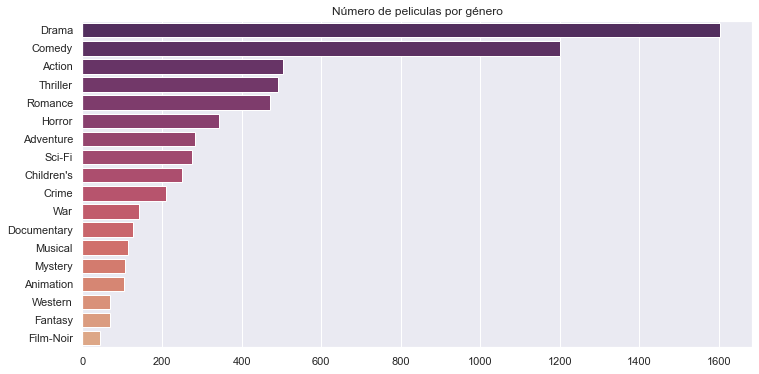

In [27]:
# Diagrama de barras numero de películas por década
# 1. Preparo datos
datos=movies_final_long.groupby('Genre').sum().reset_index().sort_values(by='Label', ascending=False)

# 2. Creo fig y axes.
fig, ax=plt.subplots(figsize=(12, 6))

# 3. Creo Plot
PxG=sns.barplot(data=datos,
                  x='Label',
                  y='Genre',
                  ci=None,
                  palette='flare_r',)

# 4. Configuracion de imagen y anotaciones 
PxG.set(title='Número de peliculas por género',
          ylabel=None,
          xlabel=None);

# Anotaciones
#for i in range(18):
#    PxG.annotate(text=int(datos.iloc[i,1]),
#                  xy=(datos.iloc[i,1]-80,i+0.25),
#                  xycoords='data',
#                  color='w',
#                  weight='bold',
#                  fontstyle='oblique');
    

En apartado anterior tambien vimos que teníamos información sobre el año de la pelicula. Vamos a ver de que años son mis películas.

In [28]:
# Distribución de la variable Año. 
movies_wide.Year.describe()

count    3883.000000
mean     1986.066959
std        16.895690
min      1919.000000
25%      1982.000000
50%      1994.000000
75%      1997.000000
max      2000.000000
Name: Year, dtype: float64

Viendo la distribución del año de grabación tenemos peliculas grabadas entre 1919 y 2000. Sin embargo, el 75% de nuestras películas es posterior a 1982. Por ello podemos decir que tenemos una filmoteca donde predominan los títulos de la década de los 80 y 90.

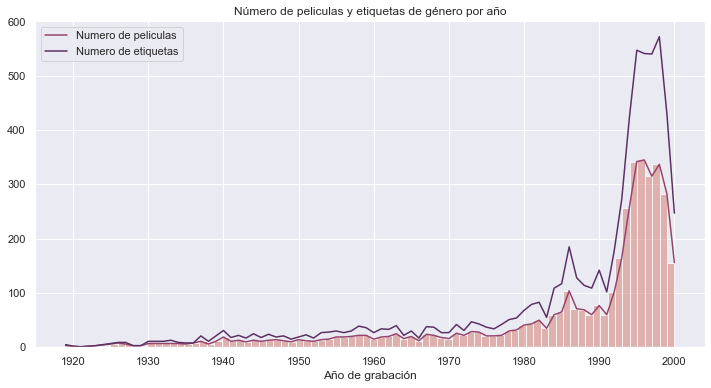

In [29]:

# Histograma de número de películas por año
# 1. Preparo datos


# 2. Creo fig y axes.
fig, ax=plt.subplots(figsize=(12, 6))

# 3. Creo Plot
PxY=sns.histplot(data=movies_wide,
                  x='Year',
                  kde=False,
                  bins=82,
                  color='#d3796e',
                  alpha=0.5,)

sns.lineplot(data=movies_wide.groupby('Year').sum(),
            y='NumMovies',
            x='Year',
            color='#94456e',
            label='Numero de peliculas',
            )
sns.lineplot(data=movies_wide.groupby('Year').sum(),
            y='NumLabels',
            x='Year',
            color='#5a3161',
            label='Numero de etiquetas',)




# 4. Configuracion de imagen y anotaciones 
PxY.set(title='Número de peliculas y etiquetas de género por año',
          ylabel=None,
          xlabel='Año de grabación');

Parece que el número de etiquetas por año y el número de películas por año están relacionados de forma lineal. Veamoslo en un diagrama de dispersión con una regresión lineal.  

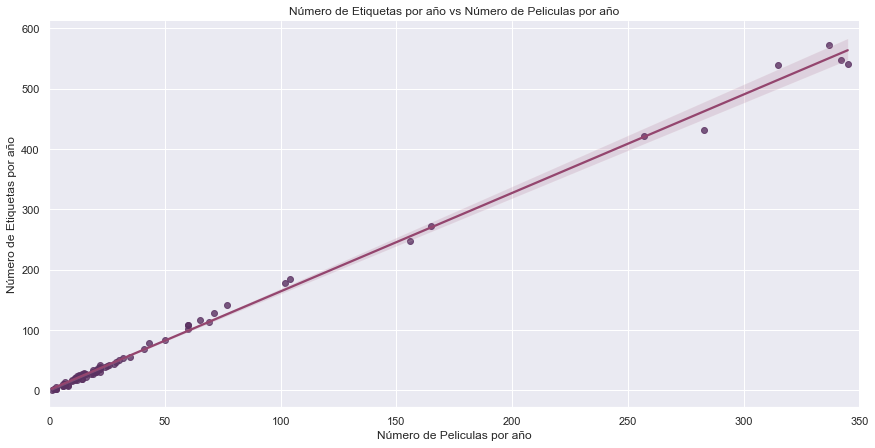

In [30]:
# Etiquetas vs peliculas

# 1. Preparo datos

# 2. Creo Plot.
lin=sns.lmplot(data=movies_wide.groupby('Year').sum(),
            x='NumMovies',
            y='NumLabels',
            height=6,
            aspect=2,
            line_kws={'color': '#94456e'},
            scatter_kws={'color': '#5a3161'})

# 3. Configuracion de imagen y anotaciones
lin.set(title='Número de Etiquetas por año vs Número de Peliculas por año',
        xlabel='Número de Peliculas por año',
        ylabel='Número de Etiquetas por año',
        xlim=(0,350));


### 2.2. Analizando las asociaciones entre géneros. 
#### 2.2.1. Matriz de co-ocurrencia entre géneros.

En la tabla generos tengo información relativa a qué generos aparecen en cada película y cuando se catalogan simultánemaente los géneros en una misma película, podemos entonces construir una matriz de co/ocurrencia o de asociaciones; la matriz de asociación o de co/ocurrencia nos da información sobre el número de ocasiones que dos variables ocurren simultáneamente. Se obtiene haciendo la multiplicación matricial de la transpuesta de la matriz por la misma matriz.


In [31]:
# Matriz de coocurrencia
X=generos.T.dot(generos).astype('int')

O más gráficamente con un heatmap anotado.

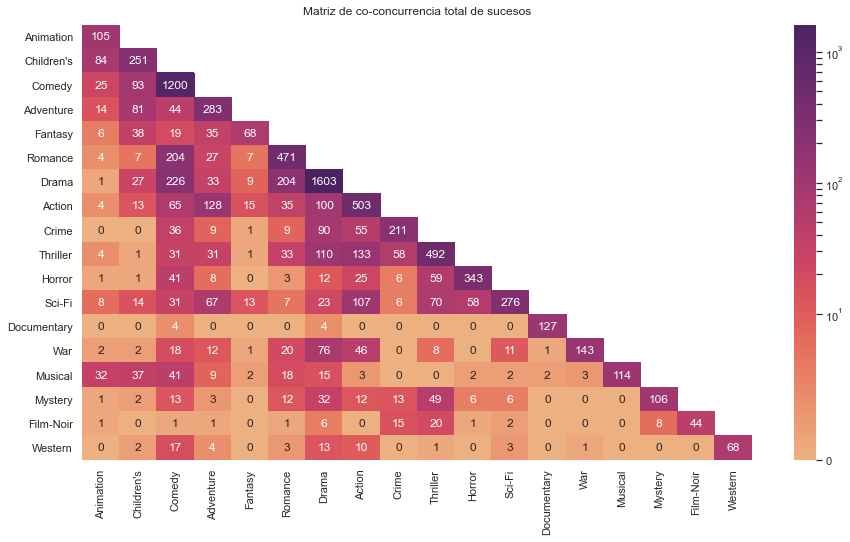

In [32]:
sns.set_style('whitegrid')
# 1. Creo fig y axes.
fig, axes = plt.subplots(figsize=(15, 8))

# 2. Dibujo plot.
sns.heatmap(X,
           annot=True, fmt='d',
           mask=np.tri(18,18,k=-1,dtype=bool).T,
           cmap='flare',
           norm=colors.SymLogNorm(linthresh=10, linscale=1,vmin=0, vmax=1605, base=10)) # Escala semilog

# 3. Añado titulo y anotaciones.
axes.set_title('Matriz de co-concurrencia total de sucesos',pad=10);



Para facilitar el análisis podemos obtener una matriz con los porcentajes, dividiendo cada columna por el elemento de la diagonal.

In [33]:
# Matriz de coocurrencia en porcentajes
X_diagonal = np.diagonal(X)
with np.errstate(divide='ignore', invalid='ignore'):
    X_pct = np.nan_to_num(np.true_divide(X, X_diagonal[:, None]))

In [34]:
X_pct=pd.DataFrame(X_pct,columns=categorias,index=categorias)
X_pct=round(X_pct,2)

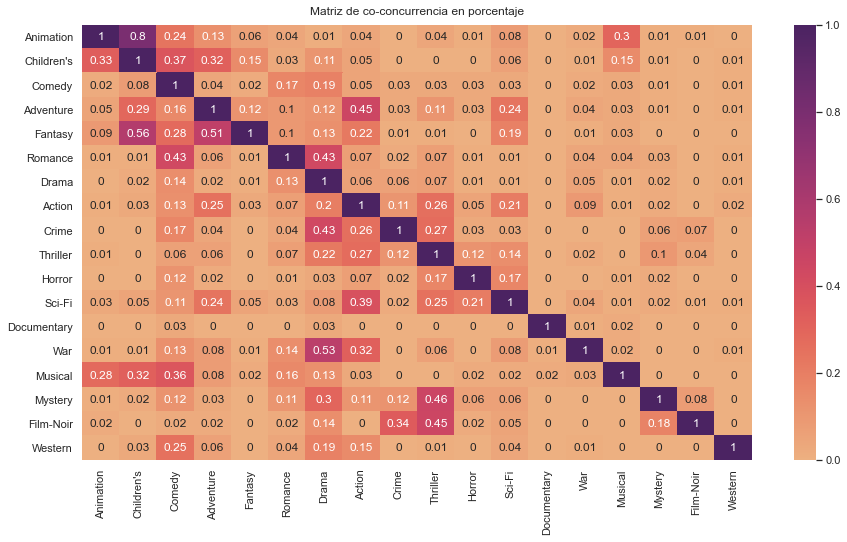

In [35]:
sns.set_theme()

# 1. Creo fig y axes.
fig, axes = plt.subplots(figsize=(15, 8))

# 2. Dibujo plot.
sns.heatmap(X_pct,
           annot=True, 
           cmap='flare',
           );

# 3. Añado titulo y anotaciones.
axes.set_title('Matriz de co-concurrencia en porcentaje',pad=10);

De este gráfico podemos afirmar lo siguiente:
- La gran mayoría de las películas de animación están etiquetadas para niños y en un 30% de las ocasiones son musicales.
- Las películas para niños suelen ser de animación, comedias o de aventuras.
- Hay dos tipos principlas de películas de romance, comedias románticas o dramas.
- El género bélico está muy asociado al drama y al género de acción.
- Las películas de acción suelen compartir género con aventuras, dramas, thriller y sci-fi.
- Casi la mitad de las peliculas de misterio están catalogadas como thrillers y hasta en una tercera parte de las ocasiones también están etiquetadas como dramas.
- Ciencia ficción es un género muy asociado a aventura, acción, thriller y horror.
- El documental es un género que se asocia en muy pocas ocasiones a otros géneros. 

### 2.3. Analizando la evolución temporal de los géneros de la filmoteca.
#### 2.3.1. Evolución de géneros más populares por año.


Vamos a ver a como se distribuyen las películas de mi filmoteca por género y año. Para ello utilizaré un mapa de calor.

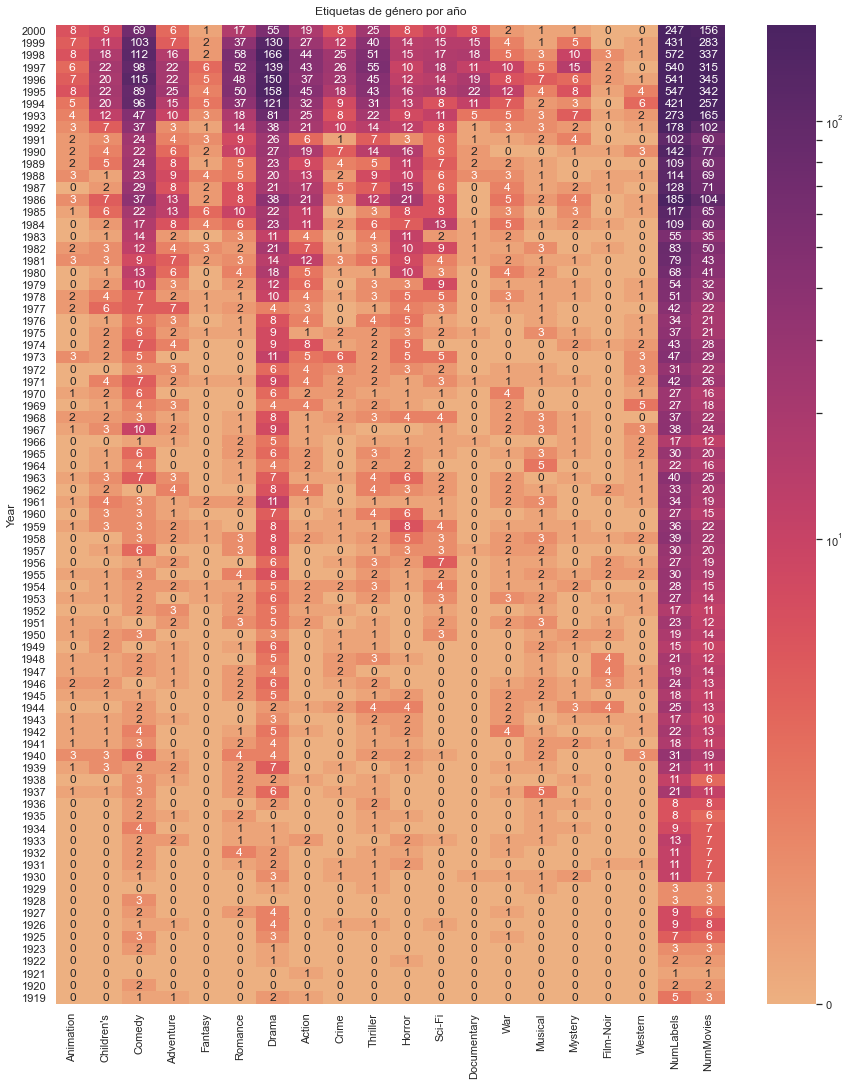

In [36]:
# Evolución de las categorías por año / Heatmap etiquetas de genero por año

# Preparo los datos
etiquetas_heatmap=movies_wide.groupby('Year').sum().iloc[:,1:-1].sort_index(ascending=False).astype('int')

# Creo la figura
plt.figure(figsize=(15,18))
gen_anual=sns.heatmap(data=etiquetas_heatmap,
            cmap='flare',
            annot=True, fmt='d',
            norm=colors.SymLogNorm(linthresh=10, linscale=1,vmin=0, vmax=170, base=10)) # Escala semilog

# Customizo los elementos de la imagen
gen_anual.set_title('Etiquetas de género por año',pad=10);



Con un vistazo al Heatmap puedo obtener la siguiente información:

- La **mayoría de las películas** de nuestra filmoteca fueron grabadas **entre 1980 y 2000**.
- Los géneros que han estado continuamente presentes son comedia y drama. 
- **Drama** es el género **más popular** en nuestra filmoteca.
- **A partir de la década de los 70** se empieza popularizar como género las películas de **acción**.
- **Sci Fi** tuvo un pequeño **boom en los 50** y después a partir de los 70 vuelve a aparecer.
- El cine de horror aparece a finales de los 50, se hace popular en los 80 y a partir de los 90 pierde fuerza como género dejando paso al thriller que se hace popular a finales de los 90.
- Las películas de **romance** estaban de moda entre los años **40 y 50** y luego perdieron importancia hasta que **vuelven a aparecer a mediados de los 80**.
- El western aparece en nuestra filmoteca en dos epocas diferentes, entre los 50s y 60s y en los 90s.
- El **documental es el género más joven** y se empieza a popularizar a mediados de los 902.


#### 2.3.1. Evolución de géneros más populares por año.

A continuación voy a analizar como han cambiado los géneros más populares por décadas en mi filmoteca. Para ello puedo agrupar por decada y por genero y añadir los totales por decada para poder crear una variable que represente el porcentaje de etiquetas por década.

In [37]:
decada=movies_final_long.groupby(['Decade','Genre']).agg({'Label':'sum',
                                                           'FactorMovie':'sum',})

In [38]:
# Etiquetas y películas Totales por decada 
decada[['Label','FactorMovie']].groupby('Decade').sum().head(3)

,Label,FactorMovie
Decade,,
20s,44.0,37.0
30s,124.0,77.0
40s,210.0,126.0


In [39]:
# Merge etiquetas y peliculas por genero y decada con totales por década.
decada=decada.merge(decada[['Label','FactorMovie']].groupby('Decade').sum(),
                    left_index=True,
                    right_index=True,
                    how='left')


In [40]:
# Renombro las columnas
decada.columns=['Label', 'Movies', 'Labels_per_decade', 'Movies_per_decade']

# Porcentage de etiquetas de cada genero por década  
decada['Pct_Genre_Decade']=round(decada.Label/decada.Labels_per_decade*100,1)
decada.head(3)


Label  Movies  Labels_per_decade  Movies_per_decade  \
Decade Genre                                                            
20s    Action       2.0     1.5               44.0               37.0   
       Adventure    2.0     1.5               44.0               37.0   
       Animation    0.0     0.0               44.0               37.0   

                  Pct_Genre_Decade  
Decade Genre                        
20s    Action                  4.5  
       Adventure               4.5  
       Animation               0.0

In [41]:
decada=decada.reset_index() # Extraigo los indices para poder dibujar el diagrama de barras

<ipython-input-42-4f15851ad2fd>:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  im=sns.barplot(data=datos[decada['Decade']==j].head(10),
<ipython-input-42-4f15851ad2fd>:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  im=sns.barplot(data=datos[decada['Decade']==j].head(10),
<ipython-input-42-4f15851ad2fd>:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  im=sns.barplot(data=datos[decada['Decade']==j].head(10),
<ipython-input-42-4f15851ad2fd>:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  im=sns.barplot(data=datos[decada['Decade']==j].head(10),
<ipython-input-42-4f15851ad2fd>:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  im=sns.barplot(data=datos[decada['Decade']==j].head(10),
<ipython-input-42-4f15851ad2fd>:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  im=sns.barplot(data=datos[decad

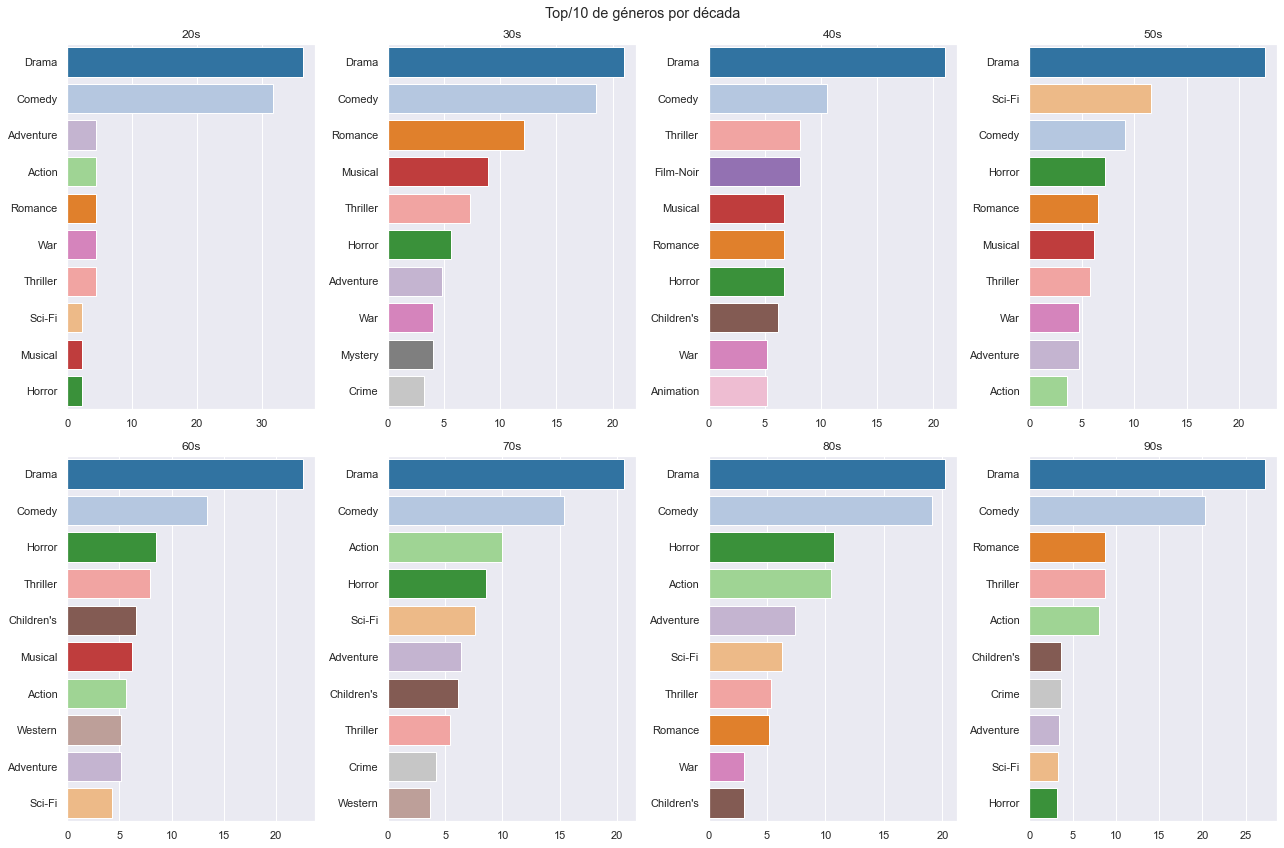

In [42]:
# Diagrama de barras con los géneros más populares por década.

# 1. Preparo los datos
datos=decada.sort_values(by='Pct_Genre_Decade',ascending=False)

# 2. Creo fig, axes y colormap.
fig,(ax)=plt.subplots(figsize=(18,12),nrows=2,ncols=4, sharey=False, tight_layout=True)

# Mapa de colores
colores={'Drama':(31/256,119/256,180/256),
         'Comedy':(174/256,199/256,232/256),
         'Romance':(255/256,127/256,14/256),
         'Sci-Fi':(255/256,187/256,120/256),
         'Horror':(44/256,160/256,44/256),
         'Action':(152/256,223/256,138/256),
         'Musical':(214/256,39/256,40/256),
         'Thriller':(255/256,152/256,150/256),
         'Film-Noir':(148/256,103/256,189/256),
         'Adventure':(197/256,176/256,213/256),
         "Children's":(140/256,86/256,75/256),
         'Western':(196/256,156/256,148/256),
         'War':(227/256,119/256,194/256),
         'Animation':(247/256,182/256,210/256),
         'Mystery':(127/256,127/256,127/256),
         'Crime':(199/256,199/256,199/256),
         'Documentary':(188/256,189/256,34/256),
         'Fantasy':(219/256,219/256,141/256)
        }

# 3. Dibujo Plot.
for i,j in enumerate(decada.Decade.unique().tolist()):
        if i <4:
            im=sns.barplot(data=datos[decada['Decade']==j].head(10),
                        x='Pct_Genre_Decade',
                        ci=None,
                        y='Genre',
                        color=colores,
                        palette=colores,
                        ax=ax[(0),i],
                        )
            im.set(title=j,
                   ylabel=None,
                   xlabel=None)
            
        else:
            im=sns.barplot(data=datos[decada['Decade']==j].head(10),
                        x='Pct_Genre_Decade',
                        ci=None,
                        y='Genre',
                        color=colores,
                        palette=colores,
                        ax=ax[1,i-4],
                        )
            im.set(title=j,
                   ylabel=None,
                   xlabel=None)
            
# 4. Añado título
fig.suptitle('Top/10 de géneros por década');


En el gráfico anterior podemos ver los generos que están en el top 10 cada década.  Vemos que el género drama siempre es el más común en nuestra biblioteca seguide de cerca por la comedia. 

Solo en los años 50 la ciencia ficcion fue capaz de desbancar a la comedia como segundo género más repetido.

Esta misma información podría quedar reflejada en un mapa de calor como el que veremos a continuación.

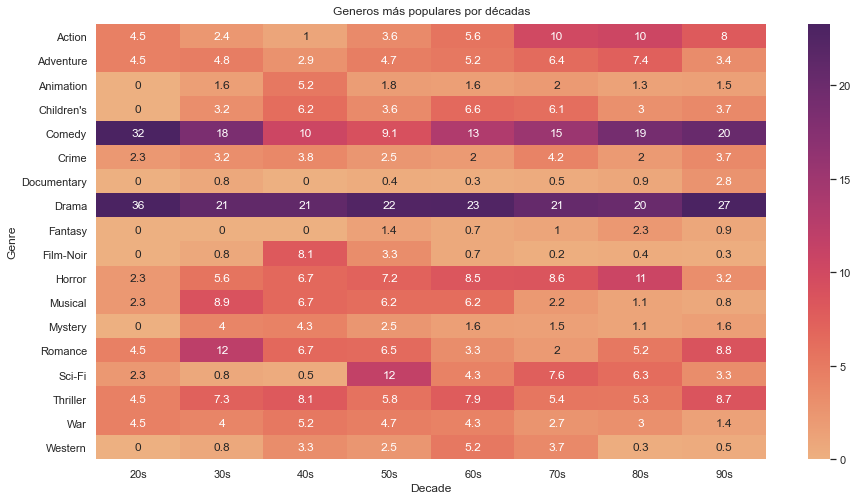

In [43]:
# Dataframe de porcentaje de géneros por década
generos_decada=decada.groupby(['Decade','Genre'])[['Pct_Genre_Decade']].sum().reset_index()

generos_decada=generos_decada.pivot(index='Genre', 
                                    columns='Decade', 
                                    values='Pct_Genre_Decade')#.sort_values(by='Genero',ascending=True)

# Representación gráfica con un heatmap.
# 1. Creo fig y axes.
fig, axes = plt.subplots(figsize=(15, 8))

#2. Dibujo plot. 
gen_dec=sns.heatmap(round(generos_decada,1),
                  annot=True, 
                  cmap='flare',
                  robust=True,
 #                norm=colors.SymLogNorm(linthresh=10, linscale=5,vmin=0, vmax=40, base=10) # Escala semilog
                  )

# 3. Añado título 
axes.set_title('Generos más populares por décadas',pad=10);


## 3. Conclusiones.

En este notebook hemos analizado una filmoteca con 3883 películas de 18 géneros diferentes. 

Partimos de una base de datos muy sencilla con tres variables donde la información estaba muy poco accesible. Sin embargo, gracias a la potencia de Numpy, la versatilidad de Pandas y la ayuda de Matplotlib y Seaborn hemos podido extraer una valiosa información.

En el punto 1 nos centramos sobre todo en extraer la información y transformar la base de datos, para quedarnos con las variables que aportarían valor a nuestro análisis. Y aquí es donde Numpy y Pandas fueron realmente útiles.

En el apartado 2 analizamos la filmoteca, buscando qué géneros eran los más populares, los años con más películas o cuales fueron las tendencias a lo largo del tiempo. 

Así vimos que la mayoría de títulos de nuestra filmoteca habian sido grabados entre 1984 y 2000. 

En este apartado descubrimos por ejemplo que el drama y la comedia son los géneros más populares, seguidos del cine de acción, thriller y romance. También observamos la evolución del cine de ciencia ficción, que tuvo su máximo explendor en los años 50 o el nacimiento de un nuevo género a mediados de los 90 como es el cine documental. Además, hemos detectado otros géneros que tuvieron relevancia en décadas pasadas, como el cine negro, el western o el cine bélico y que dejaron de rodarse en los años 80; y otros género que siempre han estado en cartelera aunque con una presencia más modesta como el cine de aventuras, peliculas para niños o la animación.



